# Part 1

1.Import libraries and Data

2.Security implications and addressing PII data

3.Regional segmentation

4.Exclusion of low-activity customer

5.Customer Profiling

6.Aggregating the max, mean, and min on a customer-profile level for usage frequency and expenditure

7.Comparing customer profiles with regions

8.Comparing customer profiles with departments

9.Additional Graphs for project analysis

# 01. Import Libraries and Data¶

In [8]:
# Import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import scipy

In [10]:
# string
path =r'/Users/juliapetke/Desktop/Career Foundry/Instacart Basket Analysis'

In [12]:
# importing dataframe
cust_ords_prods = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'orders_products_customers_merged.pkl'))

# 02. Security implications and addressing PII data

In [15]:
cust_ords_prods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   product_id              1000000 non-null  int64   
 1   product_name            975453 non-null   object  
 2   aisle_id                1000000 non-null  int64   
 3   department_id           1000000 non-null  int64   
 4   prices                  1000000 non-null  float64 
 5   order_id                1000000 non-null  int64   
 6   user_id                 1000000 non-null  object  
 7   order_number            1000000 non-null  int64   
 8   orders_day_of_week      1000000 non-null  int64   
 9   order_time_of_day       1000000 non-null  int64   
 10  days_since_prior_order  1000000 non-null  float64 
 11  add_to_cart_order       1000000 non-null  int64   
 12  reordered               1000000 non-null  int64   
 13  merge_indicator         1000000 non-null  c

The sensitive information in our dataframe includes first name and surname, gender, state, age, and marital status.

In [20]:
# remove first and last name columns
cust_ords_prods = cust_ords_prods.drop(columns=['first_name','surname'])

In [24]:
cust_ords_prods.head()

,product_id,product_name,aisle_id,department_id,prices,order_id,user_id,order_number,orders_day_of_week,order_time_of_day,...,customer_frequency,frequency_flag,gender,state,age,date_joined,n_dependants,marital_status,income,_merge
0,1,Chocolate Sandwich Cookies,61,19,5.8,3139998,138,28,6,11,...,6.0,Frequent customer,Male,Minnesota,81,8/1/2019,1,married,49620,both
1,1,Chocolate Sandwich Cookies,61,19,5.8,1977647,138,30,6,17,...,6.0,Frequent customer,Male,Minnesota,81,8/1/2019,1,married,49620,both
2,1,Chocolate Sandwich Cookies,61,19,5.8,389851,709,2,0,21,...,6.0,Frequent customer,Female,Vermont,66,6/16/2018,2,married,158302,both
3,1,Chocolate Sandwich Cookies,61,19,5.8,652770,764,1,3,13,...,4.5,Frequent customer,Female,Wisconsin,40,2/9/2020,3,married,31308,both
4,1,Chocolate Sandwich Cookies,61,19,5.8,1813452,764,3,4,17,...,4.5,Frequent customer,Female,Wisconsin,40,2/9/2020,3,married,31308,both


# 03.Regional segmentation

In [27]:
# Define regions
northeast = ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'Pennsylvania', 'New Jersey']
midwest = ['Wisconsin', 'Michigan', 'Illinois', 'Indiana', 'Ohio', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota', 'Iowa', 'Missouri']
south = ['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Kentucky', 'Tennessee', 'Mississippi', 'Alabama', 'Oklahoma', 'Texas', 'Arkansas', 'Louisiana'] 
west = ['Idaho', 'Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona', 'New Mexico', 'Alaska','Washington', 'Oregon', 'California', 'Hawaii']

In [29]:
# Create a result list for the 'state' column  showing its corresponding region
result = []

for value in cust_ords_prods['state']: 
    if value in northeast:
        result.append('Northeast')
    elif value in midwest:
        result.append('Midwest')
    elif value in south:
        result.append('South')
    elif value in west:
        result.append('West')
    else:
       result.append('No region assigned')

In [31]:
cust_ords_prods['region'] = result

In [33]:
cust_ords_prods.columns

Index(['product_id', 'product_name', 'aisle_id', 'department_id', 'prices',
       'order_id', 'user_id', 'order_number', 'orders_day_of_week',
       'order_time_of_day', 'days_since_prior_order', 'add_to_cart_order',
       'reordered', 'merge_indicator', 'price_range', 'busiest_day',
       'slowest_days', 'busiest_period_of_day', 'average_spend',
       'spender_flag', 'customer_frequency', 'frequency_flag', 'gender',
       'state', 'age', 'date_joined', 'n_dependants', 'marital_status',
       'income', '_merge', 'region'],
      dtype='object')

In [37]:
# crossing the region column with the spender flag
crosstab = pd.crosstab(cust_ords_prods['region'], cust_ords_prods['spender_flag'], dropna = False)

In [39]:
crosstab

spender_flag,High_spender,Low_spender
region,,
Midwest,48784,184620
Northeast,37612,139598
South,68912,264402
West,53153,202919


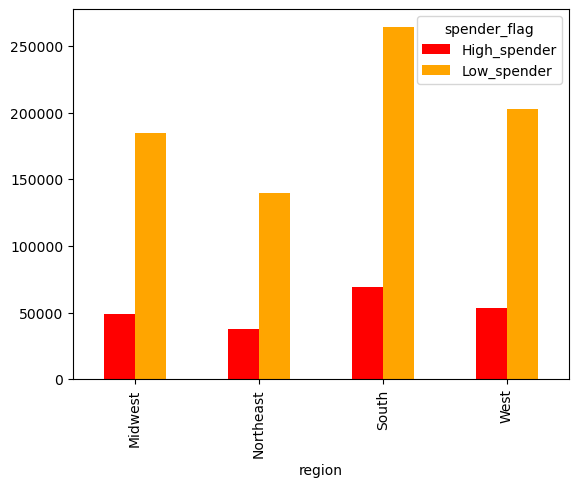

In [453]:
# create bar chart showing the difference in spending habits
region_based_spending = crosstab.plot.bar(color = ['red', 'orange'])

In [45]:
# export the bar chart
region_based_spending.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'Task 4.10-bar_region_spending_habits.png'))

# 04. Exclusion of low-activity customers¶

In [52]:
# Use groupby and transform() functions with np.max argument to determine maximum order number for each user
cust_ords_prods['max_order'] = cust_ords_prods.groupby(['user_id'])['order_number'].transform(np.max)

/var/folders/zd/kwmllg996knd4mqrwq8n_vf80000gp/T/ipykernel_72402/2054189388.py:2: FutureWarning: The provided callable <function max at 0x106f2ff60> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  cust_ords_prods['max_order'] = cust_ords_prods.groupby(['user_id'])['order_number'].transform(np.max)


In [58]:
# Use loc function to make loyalty flag column with given criteria
cust_ords_prods.loc[cust_ords_prods['max_order'] > 40, 'loyalty_flag'] = 'Loyal customer'

In [68]:
cust_ords_prods.loc[(cust_ords_prods['max_order'] <= 40) & (cust_ords_prods['max_order'] > 10), 'loyalty_flag'] = 'Regular customer'

In [70]:
cust_ords_prods.loc[cust_ords_prods['max_order'] <= 10, 'loyalty_flag'] = 'New customer'

In [72]:
# create function determining low and high activity customers
result = []

for value in cust_ords_prods['max_order']:
    if value < 5:
        result.append('low-activity customer')
    else: 
        result.append('high-activity customer')

In [74]:
#creating a new 'activity_level' column
cust_ords_prods['activity_level'] = result

In [76]:
# count number of each activity level
cust_ords_prods['activity_level'].value_counts()

activity_level
high-activity customer    921333
low-activity customer      78667
Name: count, dtype: int64

In [78]:
# exclude customers with less than 5 orders
cust_ords_prods_excluded = cust_ords_prods[cust_ords_prods['activity_level'] != 'low-activity customer']

In [80]:
# export data
cust_ords_prods_excluded.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'Task 4.10-low activity customer.pkl'))

# 05. Customer profiling¶

Creating a profiling variable based on age, income, certain goods in the “department_id” column, and number of dependents.
Analysis of “orders_day_of_week” and “order_hour_of_day” based on customer profiles.

In [84]:
cust_ords_prods_excluded.describe()

,product_id,aisle_id,department_id,prices,order_id,order_number,orders_day_of_week,order_time_of_day,days_since_prior_order,add_to_cart_order,reordered,average_spend,customer_frequency,age,n_dependants,income,max_order
count,921333.000000,921333.000000,921333.000000,921333.000000,9.213330e+05,921333.000000,921333.000000,921333.000000,921333.000000,921333.000000,921333.000000,921333.000000,921333.000000,921333.000000,921333.000000,921333.000000,921333.000000
mean,951.057029,73.931702,11.222775,7.842766,1.710036e+06,18.068122,2.763684,13.368533,10.205981,8.357177,0.593518,7.842766,9.478561,49.485026,1.499607,99881.056539,33.186606
std,608.140998,36.269671,6.066706,4.237334,9.869409e+05,17.623550,2.072916,4.243191,8.639621,7.296904,0.491177,2.683626,6.533448,18.506133,1.119376,44867.626834,24.595621
min,1.000000,1.000000,1.000000,1.000000,2.000000e+00,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,18.000000,0.000000,25911.000000,5.000000
25%,343.000000,41.000000,5.000000,3.900000,8.550270e+05,6.000000,1.000000,10.000000,4.000000,3.000000,0.000000,5.963636,5.000000,33.000000,0.000000,66927.000000,14.000000
50%,994.000000,83.000000,13.000000,8.200000,1.710947e+06,12.000000,3.000000,13.000000,7.000000,6.000000,1.000000,7.870130,7.000000,49.000000,2.000000,96658.000000,26.000000
75%,1463.000000,105.000000,16.000000,11.300000,2.564696e+06,25.000000,5.000000,16.000000,14.000000,12.000000,1.000000,9.576471,12.000000,65.000000,3.000000,128315.000000,47.000000
max,2029.000000,134.000000,21.000000,24.500000,3.421074e+06,99.000000,6.000000,23.000000,30.000000,131.000000,1.000000,24.300000,30.000000,81.000000,3.000000,593901.000000,99.000000


### Profiling based on Age

In [86]:
cust_ords_prods_excluded['age'].describe()

count    921333.000000
mean         49.485026
std          18.506133
min          18.000000
25%          33.000000
50%          49.000000
75%          65.000000
max          81.000000
Name: age, dtype: float64

In [88]:
# creating 'Young Adult' age group
cust_ords_prods_excluded.loc[cust_ords_prods_excluded['age']<=25,'age_group']='Young Adult'

/var/folders/zd/kwmllg996knd4mqrwq8n_vf80000gp/T/ipykernel_72402/3181027934.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_ords_prods_excluded.loc[cust_ords_prods_excluded['age']<=25,'age_group']='Young Adult'


In [90]:
# creating 'Adult' age group
cust_ords_prods_excluded.loc[(cust_ords_prods_excluded['age']>=26) & (cust_ords_prods_excluded['age']<=44),'age_group']='Adult'

In [92]:
# creating 'Middle-Age Adult' age group
cust_ords_prods_excluded.loc[(cust_ords_prods_excluded['age']>=45) & (cust_ords_prods_excluded['age']<=64),'age_group']='Middle-Age Adult'

In [94]:
# creating 'Senior' age group
cust_ords_prods_excluded.loc[cust_ords_prods_excluded['age']>=65,'age_group']='Senior'

In [96]:
cust_ords_prods_excluded['age_group'].value_counts()

age_group
Middle-Age Adult    290127
Adult               270568
Senior              243709
Young Adult         116929
Name: count, dtype: int64

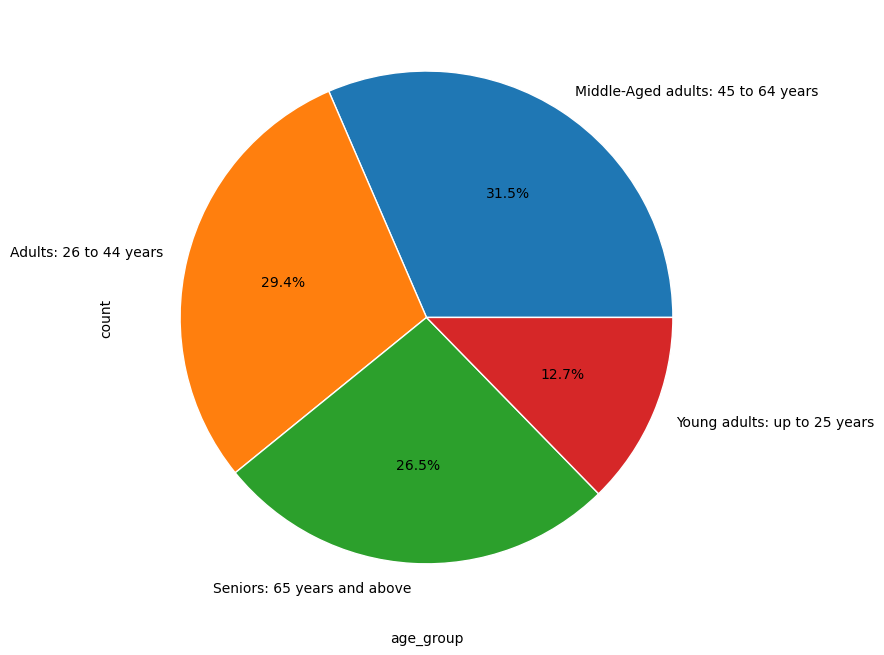

In [104]:
# Creating Pie Chart of Age Groups
age_group_counts = cust_ords_prods_excluded['age_group'].value_counts()

# Plot the pie chart
age_group_counts.plot(figsize=(12, 8))
age_group_pie_chart = age_group_counts.plot.pie(
    labels=['Middle-Aged adults: 45 to 64 years', 'Adults: 26 to 44 years','Seniors: 65 years and above','Young adults: up to 25 years'],
    autopct='%.1f%%',
    wedgeprops={'edgecolor': 'white'}
)

In [106]:
# Exporting Age Group Pie Chart
age_group_pie_chart.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','age_group_pie_chart.png'))

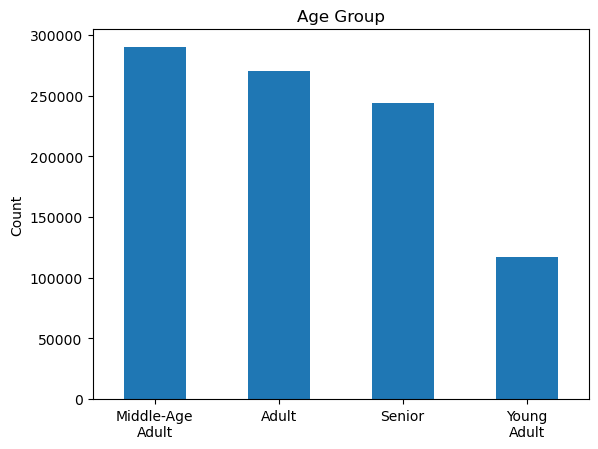

In [108]:
import matplotlib.pyplot as plt
import textwrap

age_group_bar = age_group_counts.plot.bar()
plt.title('Age Group')
plt.xlabel('')
plt.ylabel('Count')

# Wrap the x-tick labels
labels = [label.get_text() for label in age_group_bar.get_xticklabels()]
wrapped_labels = [textwrap.fill(label, 10) for label in labels]
age_group_bar.set_xticklabels(wrapped_labels, rotation=0)

plt.tight_layout
plt.show()

In [110]:
#Exporting the bar graph
age_group_bar.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'Task 4.10-age_group_bar_chart.png'))

### Profiling based on Income¶

In [113]:
cust_ords_prods_excluded['income'].describe()

count    921333.000000
mean      99881.056539
std       44867.626834
min       25911.000000
25%       66927.000000
50%       96658.000000
75%      128315.000000
max      593901.000000
Name: income, dtype: float64

In [115]:
cust_ords_prods_excluded.head()

,product_id,product_name,aisle_id,department_id,prices,order_id,user_id,order_number,orders_day_of_week,order_time_of_day,...,date_joined,n_dependants,marital_status,income,_merge,region,max_order,loyalty_flag,activity_level,age_group
0,1,Chocolate Sandwich Cookies,61,19,5.8,3139998,138,28,6,11,...,8/1/2019,1,married,49620,both,Midwest,30,Regular customer,high-activity customer,Senior
1,1,Chocolate Sandwich Cookies,61,19,5.8,1977647,138,30,6,17,...,8/1/2019,1,married,49620,both,Midwest,30,Regular customer,high-activity customer,Senior
2,1,Chocolate Sandwich Cookies,61,19,5.8,389851,709,2,0,21,...,6/16/2018,2,married,158302,both,Northeast,5,New customer,high-activity customer,Senior
5,1,Chocolate Sandwich Cookies,61,19,5.8,1701441,777,16,1,7,...,1/4/2019,2,married,57797,both,West,16,Regular customer,high-activity customer,Middle-Age Adult
7,1,Chocolate Sandwich Cookies,61,19,5.8,1290456,910,12,3,10,...,7/25/2019,0,divorced/widowed,44856,both,South,12,Regular customer,high-activity customer,Senior


In [117]:
#Creating 'low income' group
cust_ords_prods_excluded.loc[cust_ords_prods_excluded['income']<=65000,'income_group']='Low Income'

/var/folders/zd/kwmllg996knd4mqrwq8n_vf80000gp/T/ipykernel_72402/4056879043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_ords_prods_excluded.loc[cust_ords_prods_excluded['income']<=65000,'income_group']='Low Income'


In [131]:
#creating 'middle Income' group
cust_ords_prods_excluded.loc[(cust_ords_prods_excluded['income']>65000) & (cust_ords_prods_excluded['income']<=130000),'income_group']='Middle Income'

In [133]:
#Creating 'Upper Income' group
cust_ords_prods_excluded.loc[cust_ords_prods_excluded['income']>130000,'income_group']='Upper Income'

In [135]:
cust_ords_prods_excluded['income_group'].value_counts()

income_group
Middle Income    484483
Upper Income     221757
Low Income       215093
Name: count, dtype: int64

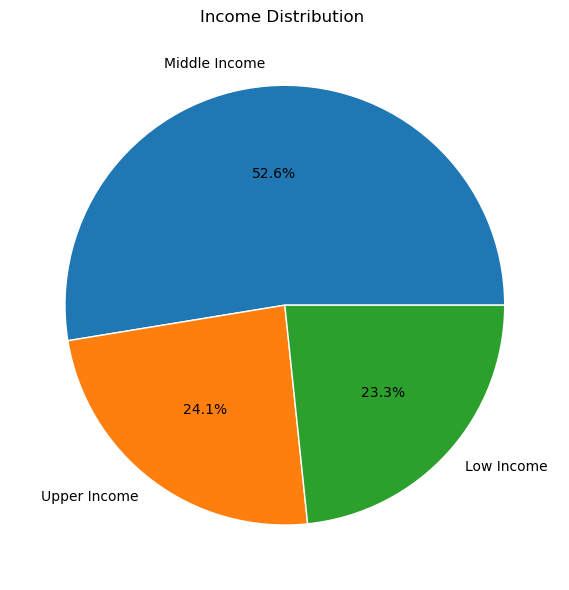

In [137]:
#creating a pie chart of Income group
income_group_counts = cust_ords_prods_excluded['income_group'].value_counts()
plt.figure(figsize=(6,6))
income_group_pie_chart=income_group_counts.plot.pie(autopct='%1.1f%%',wedgeprops={'edgecolor':'white'})
plt.title('Income Distribution ')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [139]:
# Exporting Income Distribution Pie Chart
income_group_pie_chart.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','Task 4.10-income_distribution_pie.png'))

#### Profiling based on Number of Dependents

In [150]:
cust_ords_prods_excluded['n_dependants'].describe()

count    921333.000000
mean          1.499607
std           1.119376
min           0.000000
25%           0.000000
50%           2.000000
75%           3.000000
max           3.000000
Name: n_dependants, dtype: float64

In [152]:
# creating 'low number of dependents' group
cust_ords_prods_excluded.loc[cust_ords_prods_excluded['n_dependants']<=1,'dependants_group']='Low'

/var/folders/zd/kwmllg996knd4mqrwq8n_vf80000gp/T/ipykernel_72402/995101200.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_ords_prods_excluded.loc[cust_ords_prods_excluded['n_dependants']<=1,'dependants_group']='Low'


In [154]:
# creating 'Average number of dependents' group
cust_ords_prods_excluded.loc[cust_ords_prods_excluded['n_dependants']==2,'dependants_group']='Average'

In [156]:
# creating 'Large number of dependents' group
cust_ords_prods_excluded.loc[cust_ords_prods_excluded['n_dependants']>=3,'dependants_group']='Large'

In [162]:
cust_ords_prods_excluded['dependants_group'].value_counts()

dependants_group
Low        459866
Average    231024
Large      230443
Name: count, dtype: int64

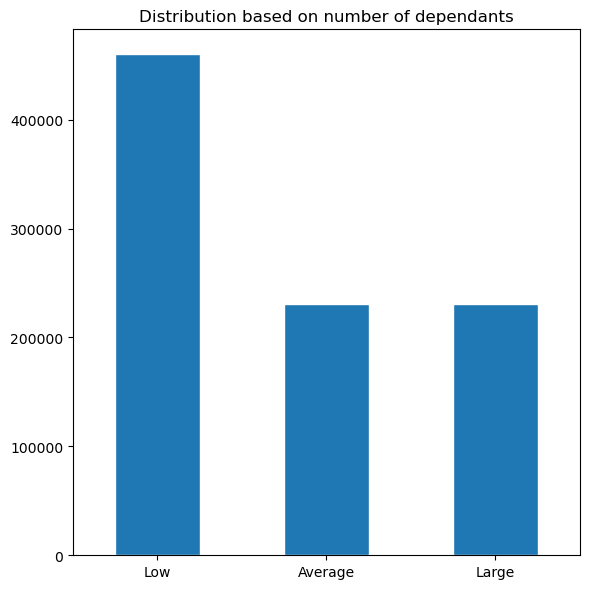

In [164]:
# Creating a bar chart of dependents groups
dependents_group_counts = cust_ords_prods_excluded['dependants_group'].value_counts()
plt.figure(figsize=(6,6))
dependent_category_bar = dependents_group_counts.plot.bar(edgecolor='white', rot=0)
plt.title('Distribution based on number of dependants')
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.show()

In [166]:
# Exporting distribution of dependents bar graph
dependent_category_bar.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','Task 4.10-dependent_distribution_bar.png'))

#### Profiling based on orders_day_of_week

In [171]:
cust_ords_prods_excluded['orders_day_of_week'].describe()

count    921333.000000
mean          2.763684
std           2.072916
min           0.000000
25%           1.000000
50%           3.000000
75%           5.000000
max           6.000000
Name: orders_day_of_week, dtype: float64

In [173]:
# Creating names for days of the week corresponding to the numbers
day_names = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}

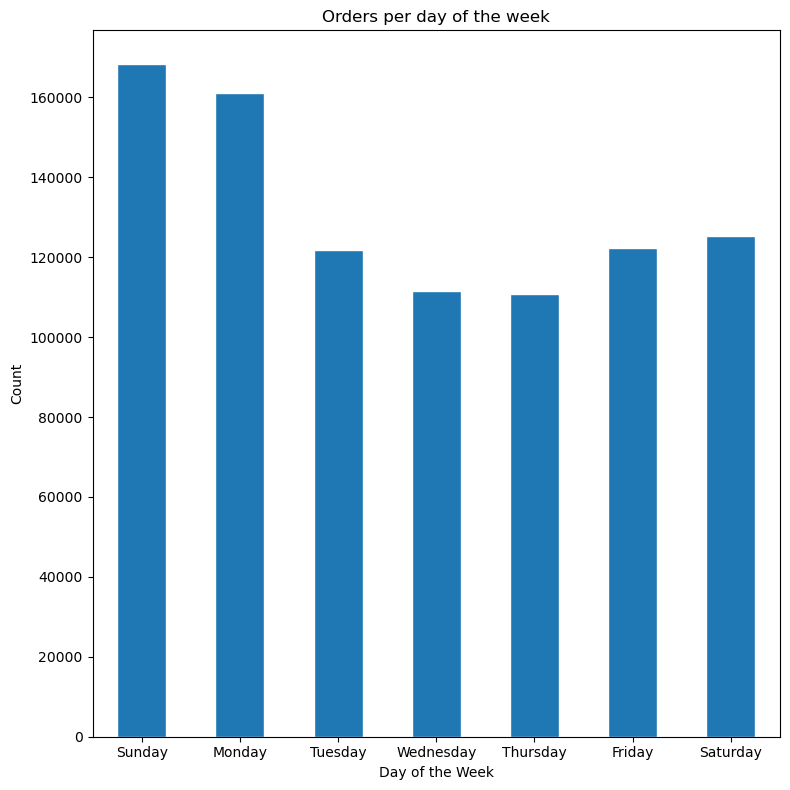

In [177]:
# Creating Bar graph
plt.figure(figsize=(8, 8))
ords_day_of_week = cust_ords_prods_excluded['orders_day_of_week'].value_counts().sort_index().plot.bar(edgecolor='white', rot=0)
plt.title('Orders per day of the week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.xticks(ticks=range(7), labels=[day_names[i] for i in range(7)])
plt.tight_layout()
plt.show()

In [179]:
# Exporting orders by day of the week bar graph
ords_day_of_week.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','Task 4.10-ords_day_of_week_bar.png'))

### Profiling based on orders per weekday/weekend

In [184]:
# creating for loop to determine if day of the week is weekday or weekend
result = []

for orders_day_of_week in cust_ords_prods_excluded['orders_day_of_week']: 
    if orders_day_of_week in [0, 6]:  # 0 and 6 represent Sunday and Saturday respectively
        result.append('Weekend')
    elif orders_day_of_week in [1, 2, 3, 4, 5]:  # 1-5 represent the weekday days
        result.append('Weekday')
    else:
        result.append('No day assigned')

cust_ords_prods_excluded['order_dow_weekend'] = result
cust_ords_prods_excluded['order_dow_weekend'].value_counts()


/var/folders/zd/kwmllg996knd4mqrwq8n_vf80000gp/T/ipykernel_72402/303149711.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_ords_prods_excluded['order_dow_weekend'] = result


order_dow_weekend
Weekday    627562
Weekend    293771
Name: count, dtype: int64

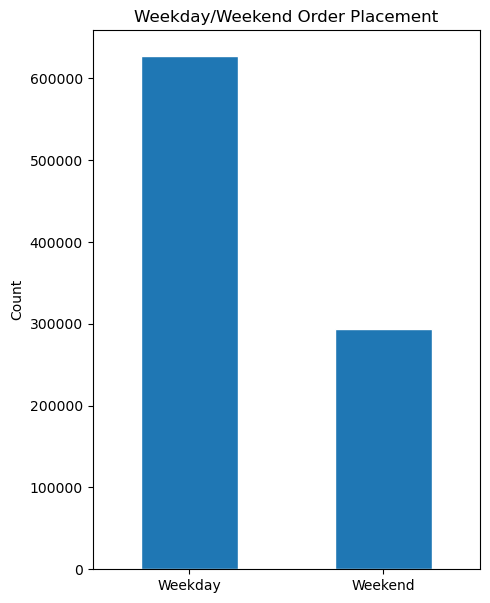

In [186]:
# Creating bar graph of Weekday Order Groups
order_dow_weekend_count = cust_ords_prods_excluded['order_dow_weekend'].value_counts()
plt.figure(figsize=(5,7))
order_dow_weekend_count_bar = order_dow_weekend_count.plot.bar(edgecolor='white', rot=0)
plt.title('Weekday/Weekend Order Placement')
plt.xlabel('')
plt.ylabel('Count')
plt.tight_layout
plt.show()

In [188]:
# exporting bar graph for weekday/weekend order placement
order_dow_weekend_count_bar.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'ords_weekday_weekend_bar.png'))

### Profiling based on order_hour_of_day

In [193]:
cust_ords_prods_excluded['order_time_of_day'].describe()

count    921333.000000
mean         13.368533
std           4.243191
min           0.000000
25%          10.000000
50%          13.000000
75%          16.000000
max          23.000000
Name: order_time_of_day, dtype: float64

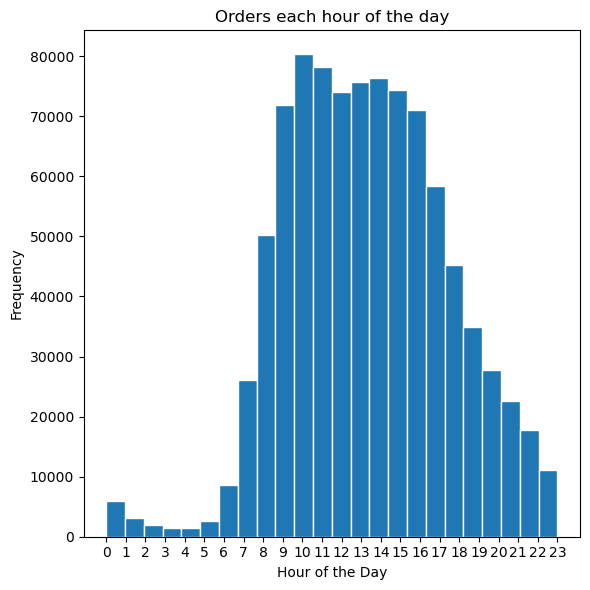

In [197]:
plt.figure(figsize=(6, 6))
ords_hour_of_day=cust_ords_prods_excluded['order_time_of_day'].plot.hist(bins=24, edgecolor='white')
plt.title('Orders each hour of the day')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

In [199]:
#exporting histogram of orders each hour of the day
ords_hour_of_day.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','Task 4.10-ords_hour_of_day_hist.png'))

### Profiling based on marital status

In [204]:
cust_ords_prods_excluded['marital_status'].value_counts()

marital_status
married                             645032
single                              152839
divorced/widowed                     78767
living with parents and siblings     44695
Name: count, dtype: int64

In [210]:
# Define get_dependents
def get_dependents(number_of_dependents):
    if number_of_dependents > 0:
        return 'Has dependents'
    else:
        return 'No dependents'

# Apply the dependents_flag function
cust_ords_prods_excluded['dependents_flag'] = cust_ords_prods_excluded['n_dependants'].apply(get_dependents)

/var/folders/zd/kwmllg996knd4mqrwq8n_vf80000gp/T/ipykernel_72402/904290127.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_ords_prods_excluded['dependents_flag'] = cust_ords_prods_excluded['n_dependants'].apply(get_dependents)


In [212]:
cust_ords_prods_excluded['dependents_flag'].value_counts()

dependents_flag
Has dependents    689727
No dependents     231606
Name: count, dtype: int64

In [214]:
# Define function to create profiles
def create_profile(row):
    return f"{row['marital_status']}, {row['dependents_flag']}"

# Apply the function to create a new column 'customer_profile'
cust_ords_prods_excluded['customer_profile'] = cust_ords_prods_excluded.apply(create_profile, axis=1)

/var/folders/zd/kwmllg996knd4mqrwq8n_vf80000gp/T/ipykernel_72402/3222472318.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_ords_prods_excluded['customer_profile'] = cust_ords_prods_excluded.apply(create_profile, axis=1)


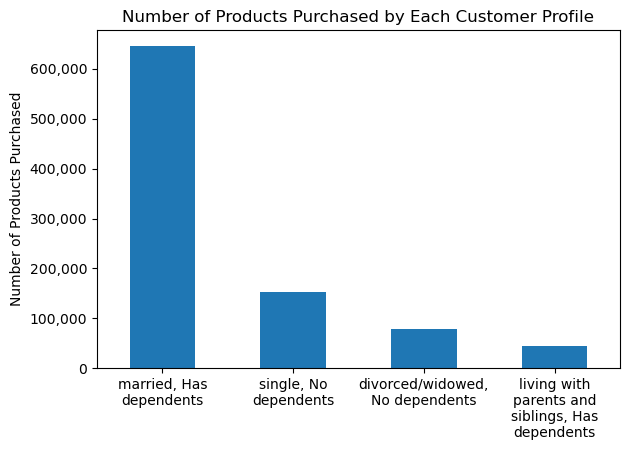

In [216]:
import textwrap
# Create chart showing distribution of customers by 'customer_profile'
counts = cust_ords_prods_excluded['customer_profile'].value_counts()
ax = counts.plot.bar()

plt.title('Number of Products Purchased by Each Customer Profile')
plt.xlabel(' ')
plt.ylabel('Number of Products Purchased')


# Format y-axis values
def value_formatter(x, pos):
    return f'{x:,.0f}'
plt.gca().yaxis.set_major_formatter(FuncFormatter(value_formatter))

# Wrap text labels
labels = [textwrap.fill(label, width=17) for label in counts.index]
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=0, ha='center')
plt.tight_layout() 

bar_customer_profile = plt.gcf()

In [218]:
#exporting histogram
ax.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','Task 4.10-customer_profile_bar.png'))

### Marital status vs. Age Group

In [221]:
crosstab_family = pd.crosstab(cust_ords_prods_excluded['marital_status'], cust_ords_prods_excluded['age_group'], dropna = False)

In [223]:
print(crosstab_family)

age_group                          Adult  Middle-Age Adult  Senior  \
marital_status                                                       
divorced/widowed                       0             18364   60403   
living with parents and siblings       0                 0       0   
married                           201867            216431  183306   
single                             68701             55332       0   

age_group                         Young Adult  
marital_status                                 
divorced/widowed                            0  
living with parents and siblings        44695  
married                                 43428  
single                                  28806  


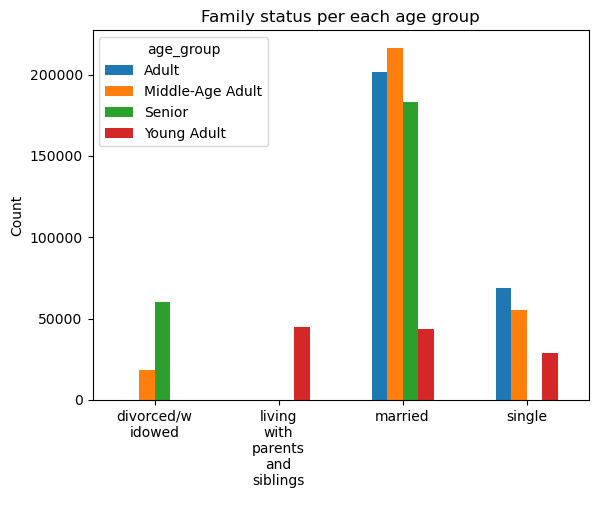

In [225]:
family_based_spending = crosstab_family.plot.bar()
plt.title('Family status per each age group')
plt.xlabel(' ')
plt.ylabel('Count')

# Get the current x-tick labels
labels = [label.get_text() for label in family_based_spending.get_xticklabels()]

# Wrap labels
wrapped_labels = [textwrap.fill(label, 10) for label in labels]

# Set the new wrapped labels
family_based_spending.set_xticklabels(wrapped_labels, rotation=0)

# Show the plot
plt.show()

In [227]:
#exporting the chart
family_based_spending.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','Task 4.10-family_based_spending.png'))

# 06. Aggregating the max, mean, and min variables on a customer-profile level for usage frequency and expenditure.

In [230]:
cust_ords_prods_excluded.columns.to_list()

['product_id',
 'product_name',
 'aisle_id',
 'department_id',
 'prices',
 'order_id',
 'user_id',
 'order_number',
 'orders_day_of_week',
 'order_time_of_day',
 'days_since_prior_order',
 'add_to_cart_order',
 'reordered',
 'merge_indicator',
 'price_range',
 'busiest_day',
 'slowest_days',
 'busiest_period_of_day',
 'average_spend',
 'spender_flag',
 'customer_frequency',
 'frequency_flag',
 'gender',
 'state',
 'age',
 'date_joined',
 'n_dependants',
 'marital_status',
 'income',
 '_merge',
 'region',
 'max_order',
 'loyalty_flag',
 'activity_level',
 'age_group',
 'income_group',
 'dependants_group',
 'order_dow_weekend',
 'dependents_flag',
 'customer_profile']

In [240]:
# Creating aggregation subset of customer profile
cust_profile_agg=cust_ords_prods_excluded.groupby(['user_id', 'gender', 'state', 'n_dependants', 'marital_status', 'order_number', 'orders_day_of_week', 'order_time_of_day', 'loyalty_flag', 'frequency_flag', 'age_group', 'income_group', 'region', 'dependants_group', 'spender_flag'])['prices'].sum().reset_index()

In [242]:
cust_profile_agg.head()

,user_id,gender,state,n_dependants,marital_status,order_number,orders_day_of_week,order_time_of_day,loyalty_flag,frequency_flag,age_group,income_group,region,dependants_group,spender_flag,prices
0,1,Female,Alabama,3,married,1,2,8,New customer,Regular customer,Adult,Low Income,South,Large,Low_spender,9.0
1,1,Female,Alabama,3,married,2,3,7,New customer,Regular customer,Adult,Low Income,South,Large,Low_spender,9.0
2,1,Female,Alabama,3,married,3,3,12,New customer,Regular customer,Adult,Low Income,South,Large,Low_spender,9.0
3,1,Female,Alabama,3,married,4,4,7,New customer,Regular customer,Adult,Low Income,South,Large,Low_spender,9.0
4,1,Female,Alabama,3,married,5,4,15,New customer,Regular customer,Adult,Low Income,South,Large,Low_spender,9.0


In [246]:
# Creating subset of user focused breakdown
customer_agg = cust_profile_agg.groupby('user_id').agg({'order_number': ['max', 'min', 'mean'], 'orders_day_of_week': ['max', 'min', 'mean'], 
                                                    'order_time_of_day': ['max', 'min', 'mean'], 'prices': ['max', 'min', 'mean']})

In [248]:
customer_agg

order_number                orders_day_of_week                \
                 max min       mean                max min      mean   
user_id                                                                
1                 10   1   5.500000                  4   1  2.500000   
10                 5   2   3.666667                  5   3  4.333333   
1000               7   6   6.500000                  6   0  3.000000   
10000             68  15  46.571429                  6   0  2.000000   
100000             8   3   5.600000                  6   0  3.000000   
...              ...  ..        ...                ...  ..       ...   
99993             20  20  20.000000                  2   2  2.000000   
99994              9   1   4.857143                  6   0  4.571429   
99995              5   3   4.000000                  6   0  4.000000   
99996             12   2   7.333333                  4   1  2.000000   
99999             34  25  29.500000                  4   1  2.500000   

        order_time_of_day                prices                   
                      max min       mean    max   min       mean  
user_id                                                           
1                      16   7  10.300000    9.0   9.0   9.000000  
10                     20  15  16.666667   11.6  10.2  11.133333  
1000                   18  16  17.000000   10.3  10.3  10.300000  
10000                  21   5  12.785714   12.7   2.7   6.435714  
100000                 16   8  14.000000   25.4   9.1  13.980000  
...                   ...  ..        ...    ...   ...        ...  
99993                  17  17  17.000000    2.5   2.5   2.500000  
99994                  20   7  11.285714   29.1   6.0  15.557143  
99995                  14  12  13.000000   17.3   4.1  10.166667  
99996                  13   8  10.000000   15.1   1.3   8.366667  
99999                  20  13  16.500000    7.7   7.7   7.700000  

[109572 rows x 12 columns]

In [250]:
# Creating aggregation by income_group for order_number & prices
income_group_agg = cust_profile_agg.groupby('income_group').agg({'order_number':['max','min','mean'],'prices':['max','min','mean']})

In [252]:
income_group_agg

order_number                prices               
                       max min       mean    max  min      mean
income_group                                                   
Low Income              99   1  17.813235   66.6  1.0  9.076837
Middle Income           99   1  18.285261   73.5  1.0  9.764232
Upper Income            99   1  18.404175   80.1  1.0  9.827712

In [256]:
# Creating aggregation by dependent_category for order_number & prices
dependent_size_agg = cust_profile_agg.groupby('dependants_group').agg({'order_number':['max','min','mean'],'prices':['max','min','mean']})

In [258]:
dependent_size_agg

order_number                prices               
                          max min       mean    max  min      mean
dependants_group                                                  
Average                    99   1  18.039886   79.4  1.0  9.631281
Large                      99   1  18.268654   80.1  1.0  9.605212
Low                        99   1  18.248500   72.0  1.0  9.613337

# 07. Comparing customer profiles with regions

In [261]:
# Creating crosstab to compare age_group profile with region locations
age_region_comparison=pd.crosstab(cust_ords_prods_excluded['age_group'],cust_ords_prods_excluded['region'],dropna=False)

In [263]:
age_region_comparison

region,Midwest,Northeast,South,West
age_group,,,,
Adult,63402,47578,90626,68962
Middle-Age Adult,67864,51245,96026,74992
Senior,56290,44069,80789,62561
Young Adult,27641,20405,39346,29537


<Figure size 1000x700 with 0 Axes>

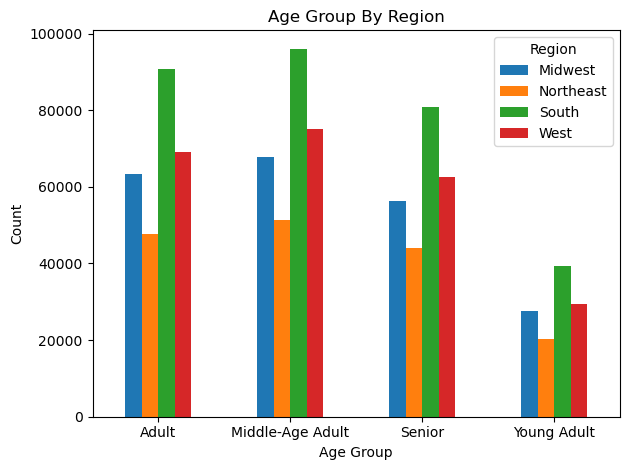

In [265]:
# Creating bar graph to show comparison between age_group and region
plt.figure(figsize=(10, 7))
age_region_comparison_bar= age_region_comparison.plot(kind='bar',rot=0)
plt.title('Age Group By Region')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Region')
plt.tight_layout()
plt.show()

In [267]:
# Exporting Age Group By Region bar graph
age_region_comparison_bar.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','Task 4.10-age_region_comparison_bar.png'))

In [269]:
# Creating crosstab to compare age_group with frequency_flag
age_customer_frequency_comparison = pd.crosstab(cust_ords_prods_excluded['age_group'], cust_ords_prods_excluded['frequency_flag'])

In [271]:
age_customer_frequency_comparison

frequency_flag,Frequent customer,Non-frequent customer,Regular customer
age_group,,,
Adult,190202,22911,57455
Middle-Age Adult,204477,24990,60660
Senior,171935,21001,50773
Young Adult,82256,9938,24735


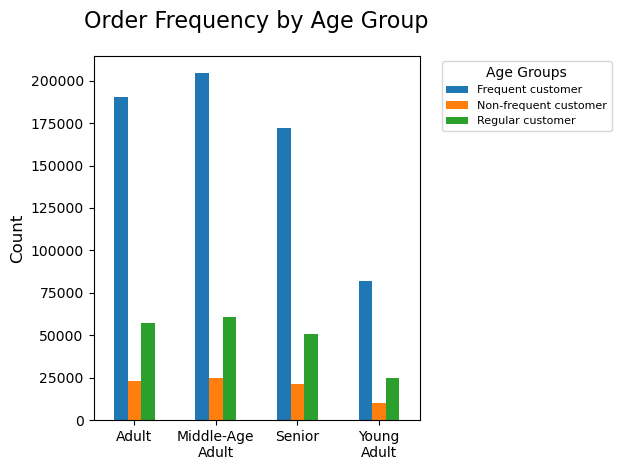

In [273]:
# create bar graph
age_cust_freq_bar = age_customer_frequency_comparison.plot.bar()

plt.title('Order Frequency by Age Group', fontsize=16, pad=20)  # Increase title font size and padding
plt.xlabel('', fontsize=12)  # Increase x-label font size
plt.ylabel('Count', fontsize=12)  # Increase y-label font size

labels = [label.get_text() for label in age_cust_freq_bar.get_xticklabels()]
wrapped_labels = [textwrap.fill(label, 10) for label in labels]
age_cust_freq_bar.set_xticklabels(wrapped_labels, rotation=0, fontsize=10)  # Increase x-tick font size

plt.legend(title='Age Groups', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)  # Increase legend font size

plt.tight_layout()  # Adjust the layout

plt.show()

In [275]:
# Exporting customer frequency by age bar graph
age_cust_freq_bar.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','Task 4.10-age_cust_freq_bar.png'))

In [277]:
# Creating crosstab Bewtween age_group and loyalty_flag
age_group_loyalty_comparison=pd.crosstab(cust_ords_prods_excluded['age_group'],cust_ords_prods_excluded['loyalty_flag'],dropna=False)

In [279]:
age_group_loyalty_comparison

loyalty_flag,Loyal customer,New customer,Regular customer
age_group,,,
Adult,83366,47163,140039
Middle-Age Adult,92643,50268,147216
Senior,75204,42547,125958
Young Adult,36938,20163,59828


<Figure size 1000x700 with 0 Axes>

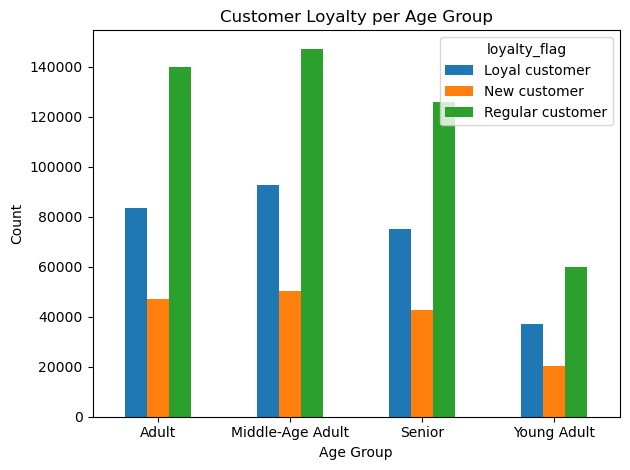

In [281]:
# Creating bar graph for customer loyalty by age group
plt.figure(figsize=(10, 7))
age_group_loaylty_comparison_bar= age_group_loyalty_comparison.plot(kind='bar', rot=0)
plt.title('Customer Loyalty per Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [283]:
# Exporting bar graph
age_group_loaylty_comparison_bar.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','Task 4.10-age_group_loaylty_comparison_bar.png'))

In [285]:
cust_ords_prods_excluded['income_group'].value_counts(dropna=False)

income_group
Middle Income    484483
Upper Income     221757
Low Income       215093
Name: count, dtype: int64

In [287]:
# creating crosstab between income_group and region
income_region_comparison=pd.crosstab(cust_ords_prods_excluded['income_group'],cust_ords_prods_excluded['region'],dropna=False)

In [289]:
income_region_comparison

region,Midwest,Northeast,South,West
income_group,,,,
Low Income,48575,37991,72554,55973
Middle Income,114241,86533,160285,123424
Upper Income,52381,38773,73948,56655


<Figure size 1000x700 with 0 Axes>

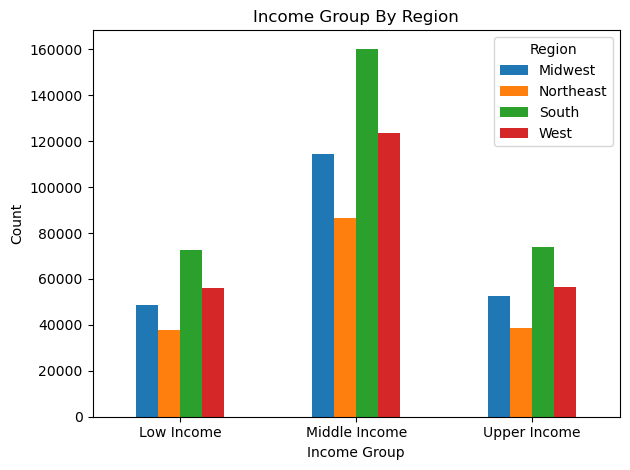

In [291]:
# Creating bar graph for income groups based on region
plt.figure(figsize=(10, 7))
income_region_comparison_bar= income_region_comparison.plot(kind='bar',rot=0)
plt.title('Income Group By Region')
plt.xlabel('Income Group')
plt.ylabel('Count')
plt.legend(title='Region')
plt.tight_layout()
plt.show()

In [295]:
# Exporting bar graph
income_region_comparison_bar.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','Task 4.10-income_region_comparison_bar.png'))

In [299]:
# Creating crosstab for dependents_group and region
dependent_group_region_comparison=pd.crosstab(cust_ords_prods_excluded['dependants_group'],cust_ords_prods_excluded['region'],dropna=False)

In [301]:
dependent_group_region_comparison

region,Midwest,Northeast,South,West
dependants_group,,,,
Average,52422,41465,78023,59114
Large,53464,40578,76503,59898
Low,109311,81254,152261,117040


<Figure size 1000x700 with 0 Axes>

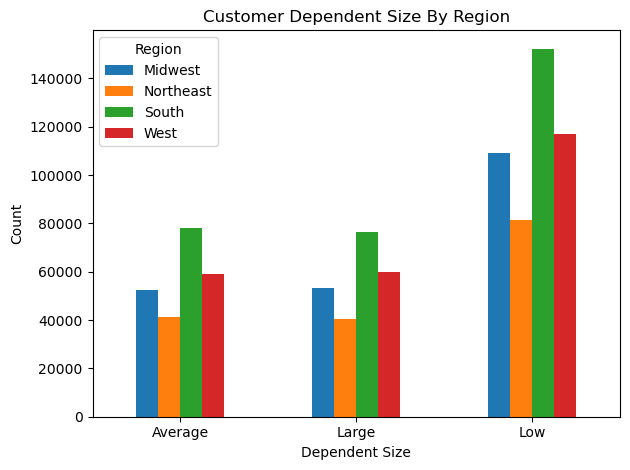

In [303]:
# Creating bar grap for dependant_group and region Comparison
plt.figure(figsize=(10, 7))
dependent_group_region_comparison_bar= dependent_group_region_comparison.plot(kind='bar',rot=0)
plt.title('Customer Dependent Size By Region')
plt.xlabel('Dependent Size')
plt.ylabel('Count')
plt.legend(title='Region')
plt.tight_layout()
plt.show()

In [305]:
# Exporting bar graph
dependent_group_region_comparison_bar.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','Task 4.10-dependent_group_region_comparison_bar.png'))

In [307]:
cust_ords_prods_excluded.head(5)

,product_id,product_name,aisle_id,department_id,prices,order_id,user_id,order_number,orders_day_of_week,order_time_of_day,...,region,max_order,loyalty_flag,activity_level,age_group,income_group,dependants_group,order_dow_weekend,dependents_flag,customer_profile
0,1,Chocolate Sandwich Cookies,61,19,5.8,3139998,138,28,6,11,...,Midwest,30,Regular customer,high-activity customer,Senior,Low Income,Low,Weekend,Has dependents,"married, Has dependents"
1,1,Chocolate Sandwich Cookies,61,19,5.8,1977647,138,30,6,17,...,Midwest,30,Regular customer,high-activity customer,Senior,Low Income,Low,Weekend,Has dependents,"married, Has dependents"
2,1,Chocolate Sandwich Cookies,61,19,5.8,389851,709,2,0,21,...,Northeast,5,New customer,high-activity customer,Senior,Upper Income,Average,Weekend,Has dependents,"married, Has dependents"
5,1,Chocolate Sandwich Cookies,61,19,5.8,1701441,777,16,1,7,...,West,16,Regular customer,high-activity customer,Middle-Age Adult,Low Income,Average,Weekday,Has dependents,"married, Has dependents"
7,1,Chocolate Sandwich Cookies,61,19,5.8,1290456,910,12,3,10,...,South,12,Regular customer,high-activity customer,Senior,Low Income,Low,Weekday,No dependents,"divorced/widowed, No dependents"


In [309]:
# Creating crosstab for order_dow_weekend by Region
week_day_weekend_region_comparison=pd.crosstab(cust_ords_prods_excluded['order_dow_weekend'],cust_ords_prods_excluded['region'],dropna=False)

In [311]:
week_day_weekend_region_comparison

region,Midwest,Northeast,South,West
order_dow_weekend,,,,
Weekday,146231,111866,208912,160553
Weekend,68966,51431,97875,75499


<Figure size 1000x700 with 0 Axes>

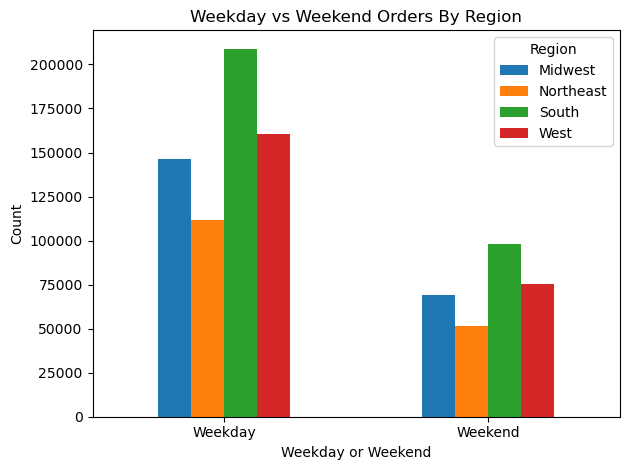

In [313]:
# Creating bar grap for weekday vs weekend By Region Comparison
plt.figure(figsize=(10, 7))
week_day_weekend_region_comparison_bar= week_day_weekend_region_comparison.plot(kind='bar',rot=0)
plt.title('Weekday vs Weekend Orders By Region')
plt.xlabel('Weekday or Weekend')
plt.ylabel('Count')
plt.legend(title='Region')
plt.tight_layout()
plt.show()

In [315]:
# Exporting bar graph
week_day_weekend_region_comparison_bar.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','Task 4.10-week_day_weekend_region_comparison_bar.png'))

In [317]:
# Creating crosstab for customer frequency and region
region_customer_frequency_comparison = pd.crosstab(cust_ords_prods_excluded['region'], cust_ords_prods_excluded['frequency_flag'])

In [319]:
region_customer_frequency_comparison

frequency_flag,Frequent customer,Non-frequent customer,Regular customer
region,,,
Midwest,150895,18571,45731
Northeast,115294,13558,34445
South,215476,26722,64589
West,167205,19989,48858


<Figure size 1000x700 with 0 Axes>

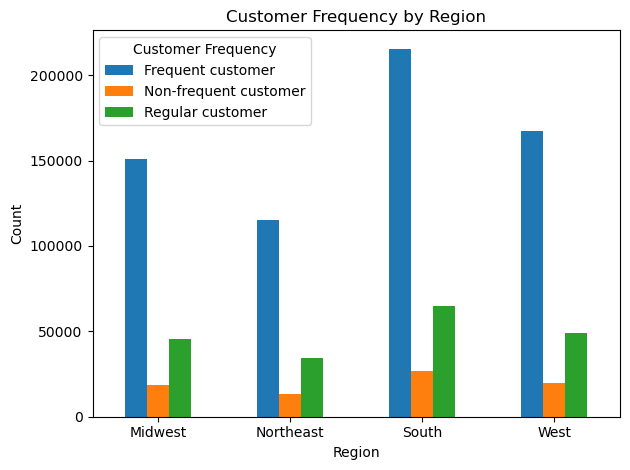

In [321]:
# Creating bar grap for customer frequency by region
plt.figure(figsize=(10, 7))
region_customer_frequency_comparison_bar= region_customer_frequency_comparison.plot(kind='bar',rot=0)
plt.title('Customer Frequency by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.legend(title='Customer Frequency')
plt.tight_layout()
plt.show()

In [323]:
# Exporting bar graph
region_customer_frequency_comparison_bar.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','Task 4.10-region_customer_frequency_comparison_bar.png'))

In [325]:
# Creating crosstab to compare region with type of spender
region_spender_type_comparison = pd.crosstab(cust_ords_prods_excluded['region'], cust_ords_prods_excluded['spender_flag'], dropna=False)

In [327]:
region_spender_type_comparison

spender_flag,High_spender,Low_spender
region,,
Midwest,43925,171272
Northeast,33917,129380
South,61690,245097
West,47708,188344


<Figure size 1000x700 with 0 Axes>

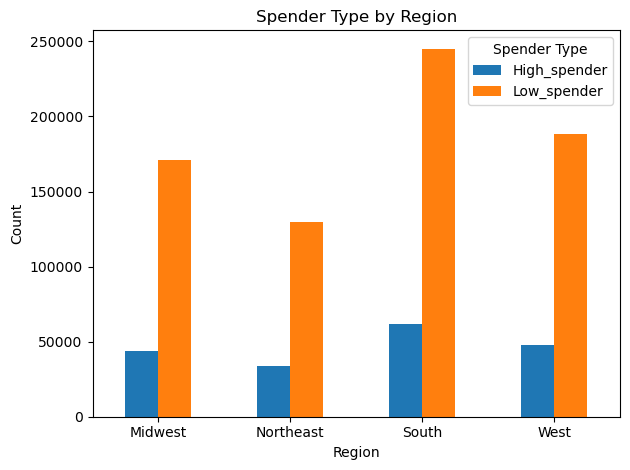

In [329]:
# Creating bar grap for type of spender by region
plt.figure(figsize=(10, 7))
region_spender_type_comparison_bar= region_spender_type_comparison.plot(kind='bar',rot=0)
plt.title('Spender Type by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.legend(title='Spender Type')
plt.tight_layout()
plt.show()

In [331]:
# Exporting bar graph
region_spender_type_comparison_bar.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','Task 4.10-region_spender_type_comparison_bar.png'))

# 08. Comparing customer profiles with departments

In [336]:
#Importing department wrangled dataframe                 
df_dept = pd.read_csv(os.path.join(path,'02 Data', 'Prepared Data', 'df_dep_t_new_wrangled.csv'), index_col=False)

In [340]:
df_dept.rename(columns = {'Unnamed: 0': 'department_id'}, inplace = True)

In [342]:
df_dept

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [344]:
df_dept.dtypes

department_id     int64
department       object
dtype: object

In [346]:
# Changing department_id from int64 to str for merge
df_dept['department_id'] = df_dept['department_id'].astype('float64')

In [348]:
cust_ords_prods_excluded.columns.to_list()

['product_id',
 'product_name',
 'aisle_id',
 'department_id',
 'prices',
 'order_id',
 'user_id',
 'order_number',
 'orders_day_of_week',
 'order_time_of_day',
 'days_since_prior_order',
 'add_to_cart_order',
 'reordered',
 'merge_indicator',
 'price_range',
 'busiest_day',
 'slowest_days',
 'busiest_period_of_day',
 'average_spend',
 'spender_flag',
 'customer_frequency',
 'frequency_flag',
 'gender',
 'state',
 'age',
 'date_joined',
 'n_dependants',
 'marital_status',
 'income',
 '_merge',
 'region',
 'max_order',
 'loyalty_flag',
 'activity_level',
 'age_group',
 'income_group',
 'dependants_group',
 'order_dow_weekend',
 'dependents_flag',
 'customer_profile']

In [350]:
cust_ords_prods_excluded.shape

(921333, 40)

In [374]:
cust_ords_prods_excluded = cust_ords_prods_excluded.drop(columns=['_merge'], errors='ignore')
df_final_dept = cust_ords_prods_excluded.merge(df_dept, on='department_id', indicator=True)

In [376]:
df_final_dept

,product_id,product_name,aisle_id,department_id,prices,order_id,user_id,order_number,orders_day_of_week,order_time_of_day,...,loyalty_flag,activity_level,age_group,income_group,dependants_group,order_dow_weekend,dependents_flag,customer_profile,department,_merge
0,1,Chocolate Sandwich Cookies,61,19,5.8,3139998,138,28,6,11,...,Regular customer,high-activity customer,Senior,Low Income,Low,Weekend,Has dependents,"married, Has dependents",snacks,both
1,1,Chocolate Sandwich Cookies,61,19,5.8,1977647,138,30,6,17,...,Regular customer,high-activity customer,Senior,Low Income,Low,Weekend,Has dependents,"married, Has dependents",snacks,both
2,1,Chocolate Sandwich Cookies,61,19,5.8,389851,709,2,0,21,...,New customer,high-activity customer,Senior,Upper Income,Average,Weekend,Has dependents,"married, Has dependents",snacks,both
3,1,Chocolate Sandwich Cookies,61,19,5.8,1701441,777,16,1,7,...,Regular customer,high-activity customer,Middle-Age Adult,Low Income,Average,Weekday,Has dependents,"married, Has dependents",snacks,both
4,1,Chocolate Sandwich Cookies,61,19,5.8,1290456,910,12,3,10,...,Regular customer,high-activity customer,Senior,Low Income,Low,Weekday,No dependents,"divorced/widowed, No dependents",snacks,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921328,2029,Swirl Thick Slice Brown Sugar Cinnamon Bread,112,3,8.3,528537,63700,13,5,14,...,Regular customer,high-activity customer,Senior,Middle Income,Low,Weekday,No dependents,"divorced/widowed, No dependents",bakery,both
921329,2029,Swirl Thick Slice Brown Sugar Cinnamon Bread,112,3,8.3,3000197,63700,14,1,14,...,Regular customer,high-activity customer,Senior,Middle Income,Low,Weekday,No dependents,"divorced/widowed, No dependents",bakery,both
921330,2029,Swirl Thick Slice Brown Sugar Cinnamon Bread,112,3,8.3,2372562,65043,37,3,11,...,Loyal customer,high-activity customer,Middle-Age Adult,Middle Income,Large,Weekday,Has dependents,"married, Has dependents",bakery,both
921331,2029,Swirl Thick Slice Brown Sugar Cinnamon Bread,112,3,8.3,2027185,65162,8,5,14,...,Regular customer,high-activity customer,Young Adult,Middle Income,Low,Weekday,No dependents,"single, No dependents",bakery,both


In [378]:
df_final_dept['department'].value_counts()

department
dairy eggs         208222
produce            113078
frozen              95458
beverages           93806
snacks              69999
pantry              62418
canned goods        60005
household           40136
breakfast           35002
dry goods pasta     28623
deli                21147
babies              18737
bakery              18457
personal care       14469
meat seafood        13439
international       11960
alcohol              7354
pets                 4781
bulk                 2491
missing              1122
other                 629
Name: count, dtype: int64

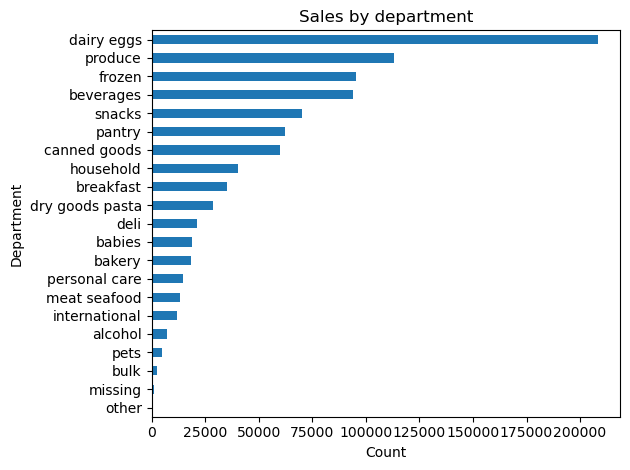

In [380]:
# Creating department bar graph
dept_bar = df_final_dept['department'].value_counts().sort_values(ascending=True).plot(kind='barh')
plt.title('Sales by department')
plt.xlabel('Count')
plt.ylabel('Department')
plt.tight_layout()

In [382]:
# Exporting bar graph
dept_bar.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','Task 4.10-department_product_bar.png'))

In [386]:
# Exporting new dataframe with department merged to main dataframe
df_final_dept.to_pickle(os.path.join(path,'02 Data','Prepared Data','Task 4.10-orders_products_customer_department_merge.pkl'))

In [388]:
# Creating crosstab to compare age_group with departments
age_department_comparison=pd.crosstab(df_final_dept['age_group'],df_final_dept['department'],dropna=False)

In [390]:
age_department_comparison

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
age_group,,,,,,,,,,,,,,,,,,,,,
Adult,2253,5474,5215,27342,10231,736,18017,61081,5994,8591,...,11896,3540,4097,308,178,18424,4147,1295,33407,20565
Middle-Age Adult,2285,5836,5727,29619,11183,808,18578,65468,7184,8841,...,12415,3701,4381,353,204,19365,4610,1634,35351,22067
Senior,1733,5136,4927,25075,9212,609,15835,55477,5370,7501,...,10614,3242,3358,326,167,16630,3875,1139,30184,18095
Young Adult,1083,2291,2588,11770,4376,338,7575,26196,2599,3690,...,5211,1477,1603,135,80,7999,1837,713,14136,9272


<Figure size 2500x2500 with 0 Axes>

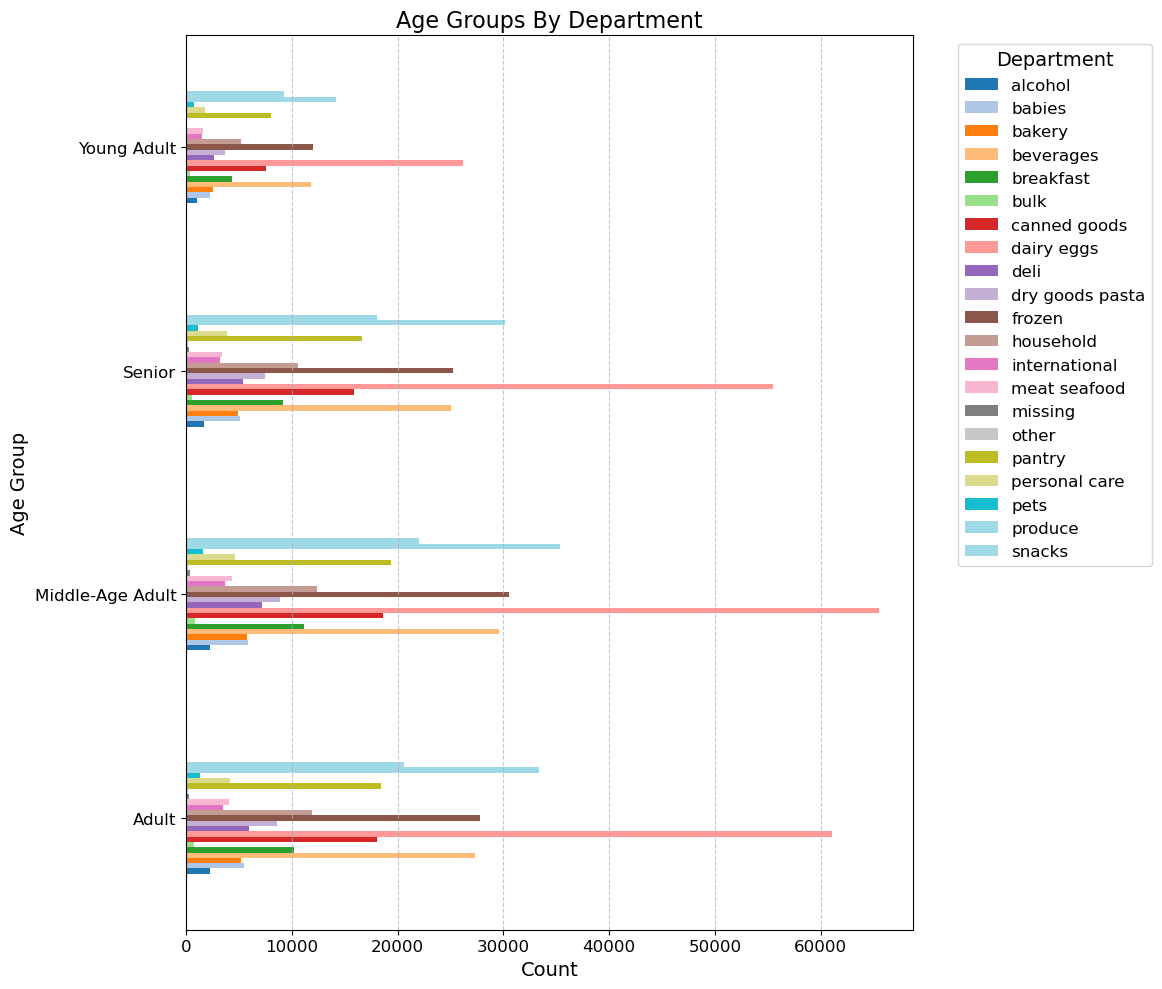

In [392]:
plt.figure(figsize=(25, 25))
age_department_comparison_bar = age_department_comparison.plot(kind='barh', figsize=(14, 10), colormap='tab20', rot=0)

# Add title and labels with larger font size
plt.title('Age Groups By Department', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Age Group', fontsize=14)

# Increase font size for ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Move legend outside of plot
plt.legend(title='Department', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)

# Add gridlines
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adjust layout to make room for legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

In [394]:
# Exporting bar graph
age_department_comparison_bar.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','Task 4.10-age_department_comparison_bar.png'))

In [396]:
# Creating crosstab to compare income_group with departments
income_group_department_comparison=pd.crosstab(df_final_dept['income_group'],df_final_dept['department'],dropna=False)

In [398]:
income_group_department_comparison

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
income_group,,,,,,,,,,,,,,,,,,,,,
Low Income,2048,3455,5223,31998,7920,689,11810,44854,4042,5553,...,9373,2381,2377,224,134,12925,3296,930,21107,22528
Middle Income,3328,10702,9223,42170,18547,1270,33186,113000,11880,15969,...,20743,6634,7281,630,351,34065,7514,2555,62951,32431
Upper Income,1978,4580,4011,19638,8535,532,15009,50368,5225,7101,...,10020,2945,3781,268,144,15428,3659,1296,29020,15040


<Figure size 1800x1200 with 0 Axes>

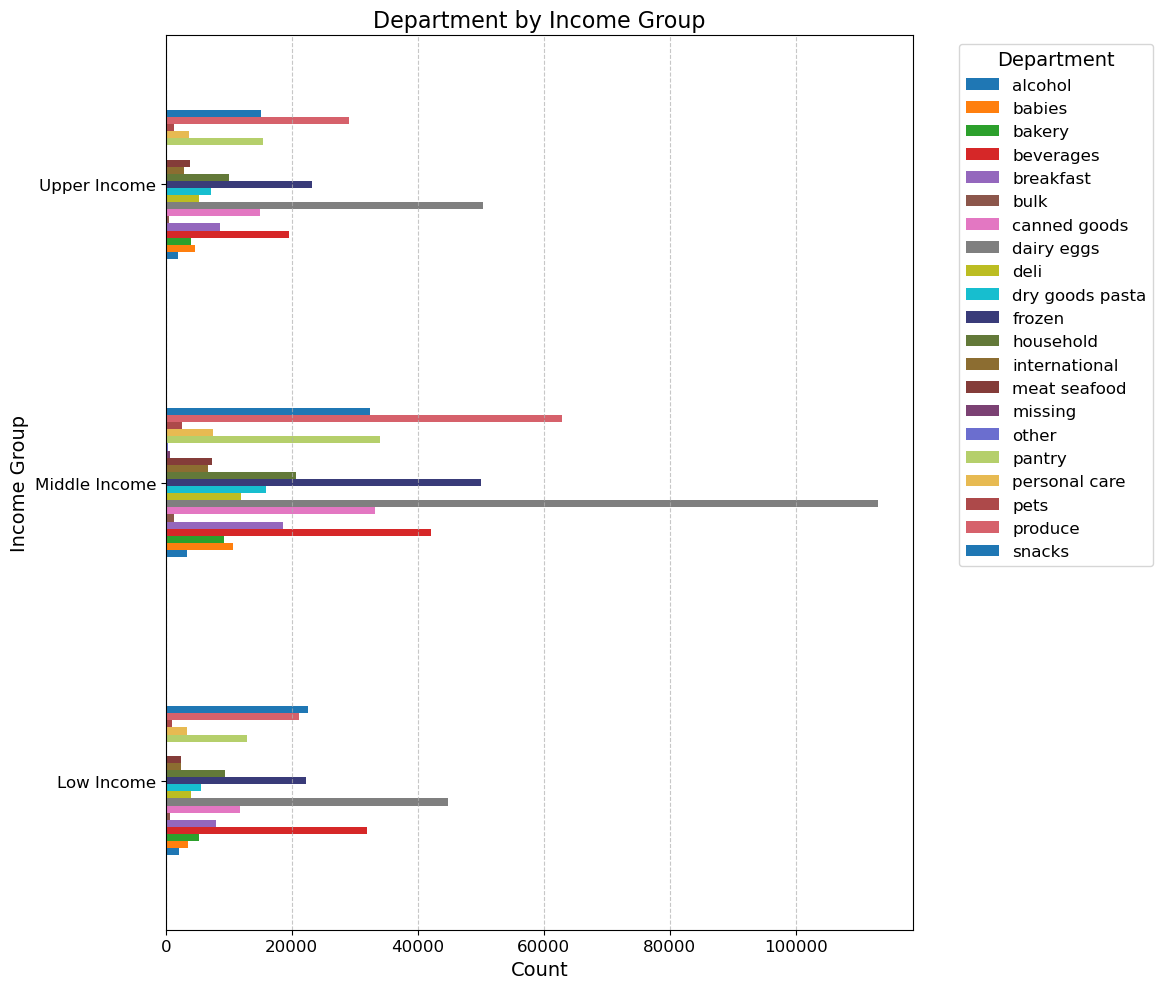

In [400]:
# Define a custom color palette with distinct colors
custom_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#393b79', '#637939', '#8c6d31', '#843c39', '#7b4173',
    '#6b6ecf', '#b5cf6b', '#e7ba52', '#ad494a', '#d6616b'
]

# Create a bar chart with custom colors
plt.figure(figsize=(18, 12))
income_group_department_comparison_bar = income_group_department_comparison.plot(
    kind='barh',
    figsize=(14, 10),
    color=custom_colors,
    rot=0
)

# Add title and labels with larger font size
plt.title('Department by Income Group', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Income Group', fontsize=14)

# Increase font size for ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Move legend outside of plot
plt.legend(title='Department', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)

# Add gridlines
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adjust layout to make room for legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

In [402]:
# Exporting bar graph
income_group_department_comparison_bar.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','Task 4.10-income_group_department_comparison_bar.png'))

In [404]:
# Creating crosstab to compare regions with departments
region_dept_comparison = pd.crosstab(df_final_dept['region'], df_final_dept['department'], dropna = False)

In [406]:
region_dept_comparison

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
region,,,,,,,,,,,,,,,,,,,,,
Midwest,1655,4488,4022,21384,7965,590,14059,49229,4984,6842,...,9457,2852,3198,271,156,14367,3503,1241,26319,15913
Northeast,1488,3396,3528,17452,6454,450,10365,36174,3615,5003,...,7176,2034,2436,209,125,10958,2499,1019,19689,12799
South,2360,6432,6333,31253,11669,726,20090,69032,7348,9490,...,13419,3925,4298,406,193,20831,4878,1393,37326,23226
West,1851,4421,4574,23717,8914,725,15491,53787,5200,7288,...,10084,3149,3507,236,155,16262,3589,1128,29744,18061


<Figure size 1000x800 with 0 Axes>

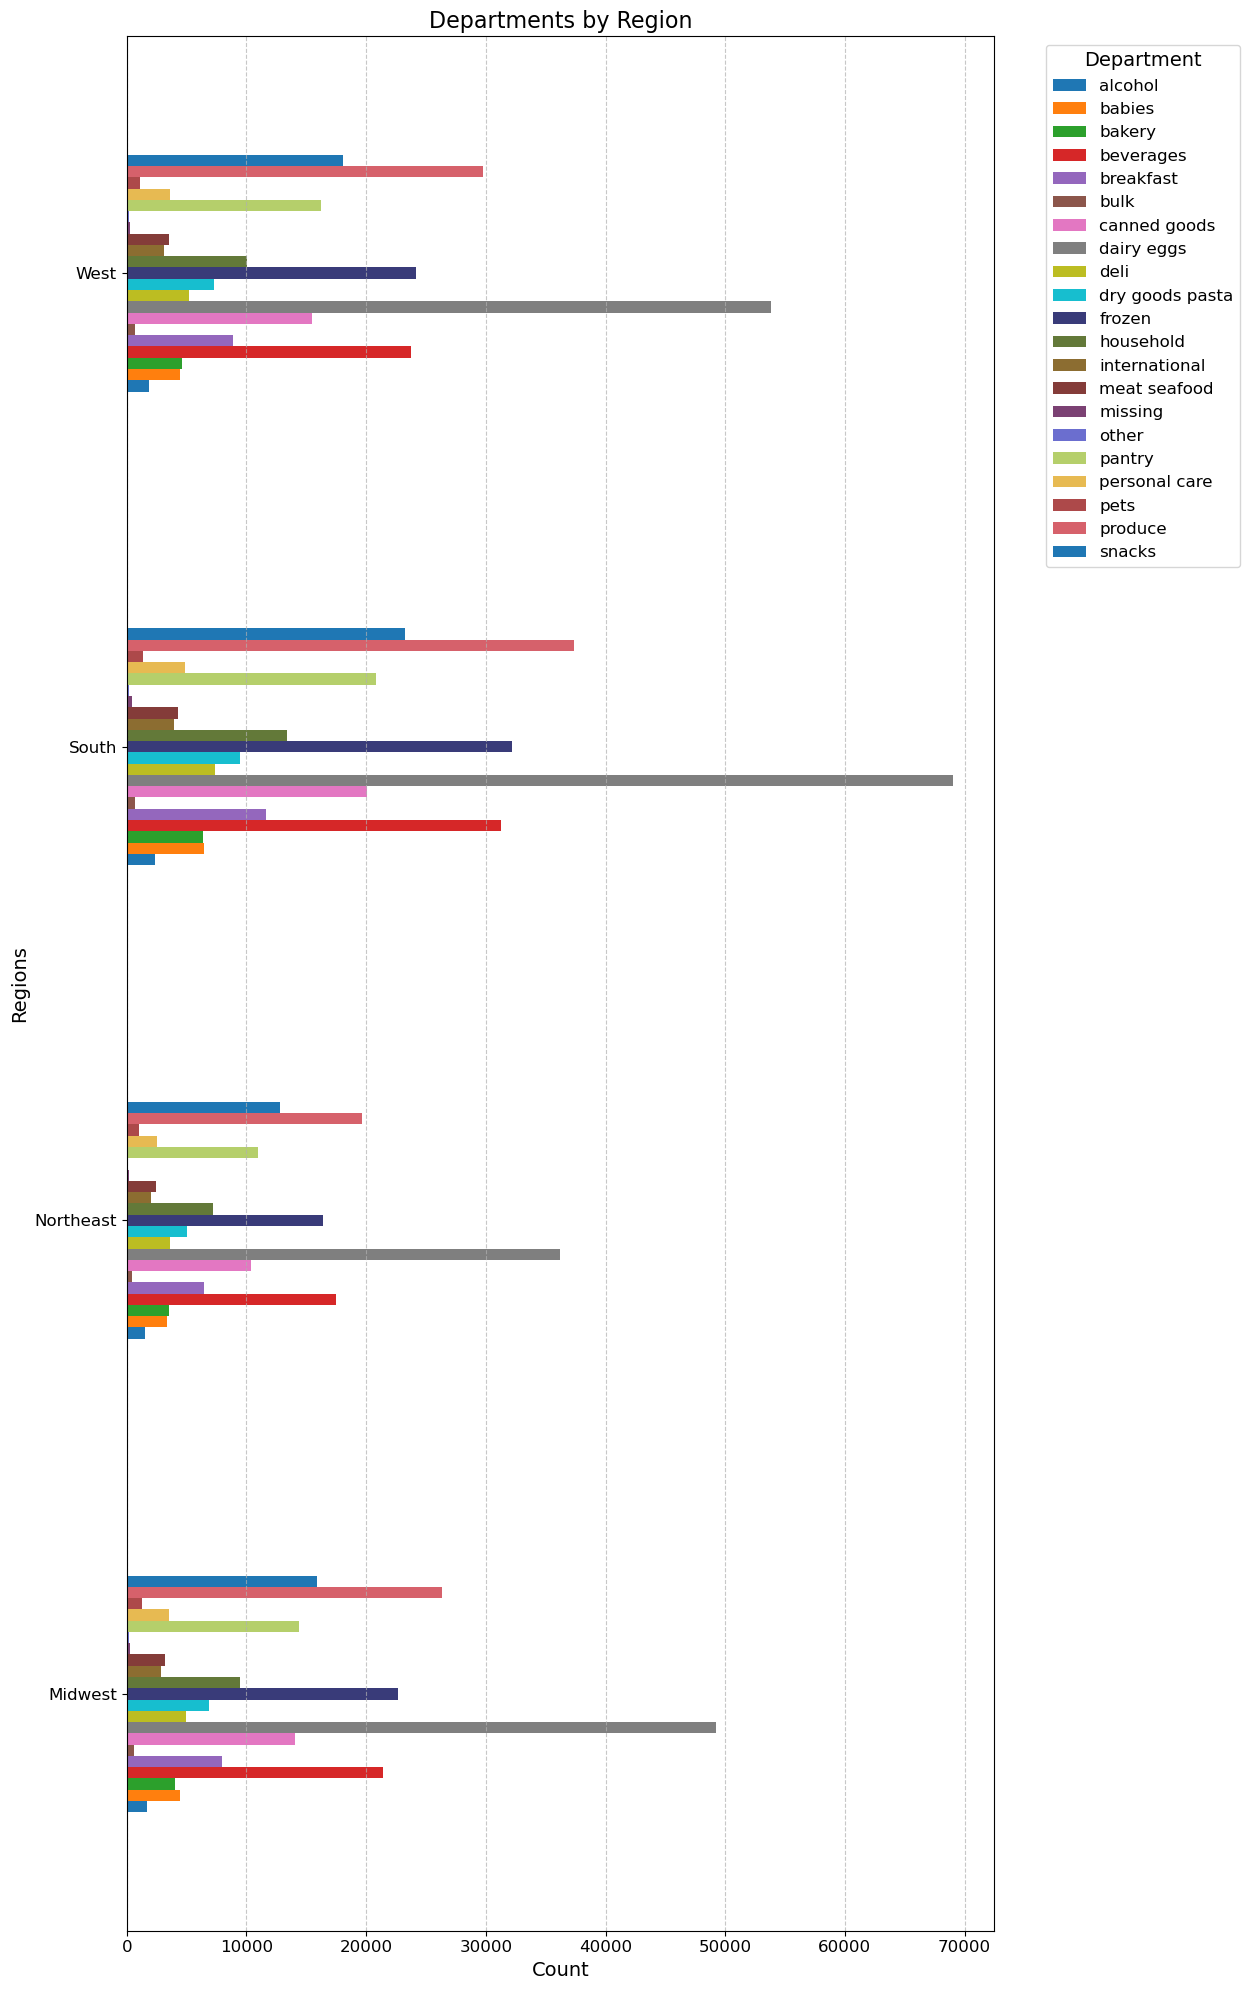

In [408]:
# Define a custom color palette with distinct colors
custom_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#393b79', '#637939', '#8c6d31', '#843c39', '#7b4173',
    '#6b6ecf', '#b5cf6b', '#e7ba52', '#ad494a', '#d6616b'
]

plt.figure(figsize=(10, 8))
region_dept_comparison_bar = region_dept_comparison.plot(kind='barh', figsize=(15, 20), color = custom_colors, rot=0)

# Add title and labels with larger font size
plt.title('Departments by Region', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Regions', fontsize=14)

# Increase font size for ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Move legend outside of plot
plt.legend(title='Department', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)

# Add gridlines
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adjust layout to make room for legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

In [410]:
# Exporting Regions by Department Bar Chart
region_dept_comparison_bar.figure.savefig(os.path.join(path, '04 Analysis','Visualizations','Task4.10-region_dept_compparison_bar.png'))

# 09. Additional Graphs for project analysis

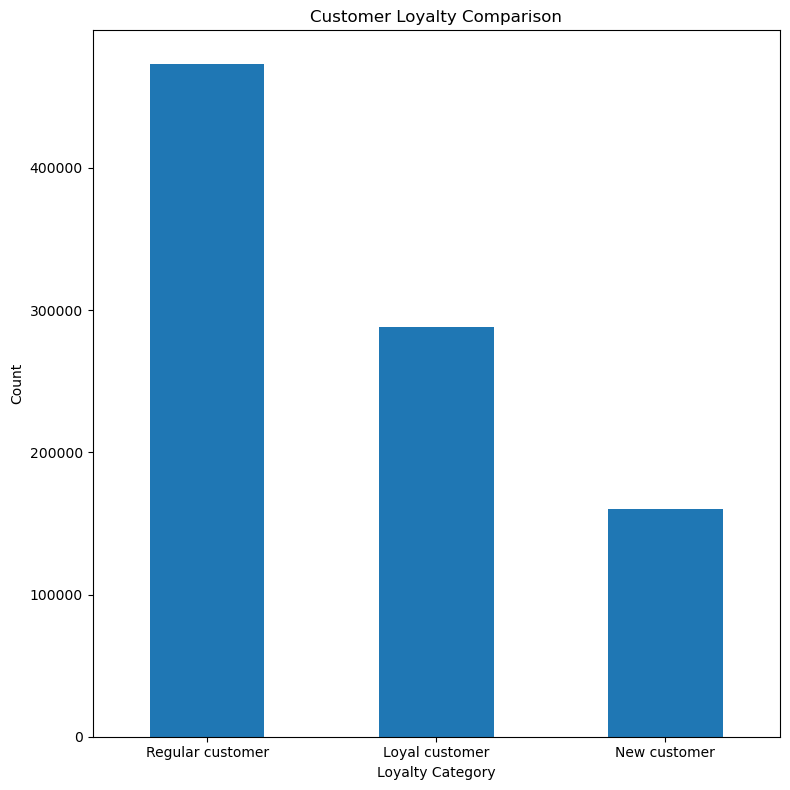

In [419]:
# Creating bar graph for customer loyalty breakdown
plt.figure(figsize = (8,8))
loyalty_customer_comparison_bar = cust_ords_prods_excluded['loyalty_flag'].value_counts().plot(kind = 'bar', rot = 0)
plt.title('Customer Loyalty Comparison')
plt.xlabel('Loyalty Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [423]:
# Exporting graph
loyalty_customer_comparison_bar.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','Task 4.10-loyalty_customer_comparison_bar.png'))

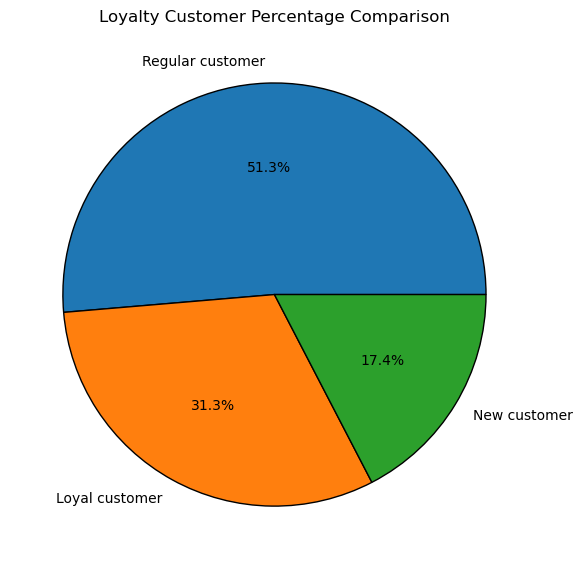

In [425]:
# Creating pie Chart of customer loyalty breakdown
loyalty_customer_pie = cust_ords_prods_excluded['loyalty_flag'].value_counts()
plt.figure(figsize = (6,6))
loyalty_customer_comparison_pie = loyalty_customer_pie.plot.pie(autopct = '%.1f%%', wedgeprops = {'edgecolor':'black'})
plt.title('Loyalty Customer Percentage Comparison')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [427]:
# Exporting graph
loyalty_customer_comparison_pie.figure.savefig(os.path.join(path,'04 Analysis','Visualizations','Task4.10-loyalty_customer_comparison_pie.png'))

In [451]:
cust_ords_prods['busiest_period_of_day'].value_counts()

busiest_period_of_day
Most orders       652729
Average orders    307666
Fewest orders      39605
Name: count, dtype: int64